# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


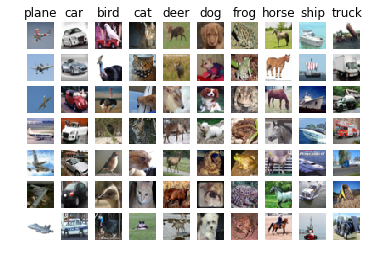

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


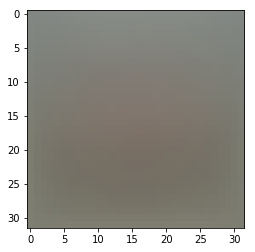

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.357117


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -14.504248 analytic: -14.504248, relative error: 5.040314e-13
numerical: 8.238786 analytic: 8.238786, relative error: 5.245035e-11
numerical: -11.748661 analytic: -11.748661, relative error: 1.500822e-11
numerical: 31.945226 analytic: 31.945226, relative error: 7.074627e-12
numerical: -2.133373 analytic: -2.133373, relative error: 1.054957e-10
numerical: 14.246935 analytic: 14.246935, relative error: 4.743581e-13
numerical: 1.362021 analytic: 1.362021, relative error: 9.427860e-11
numerical: -33.539966 analytic: -33.539966, relative error: 4.495342e-12
numerical: 6.755003 analytic: 6.755003, relative error: 9.875145e-12
numerical: -12.820682 analytic: -12.820682, relative error: 4.037256e-12
numerical: -0.948241 analytic: -0.948241, relative error: 6.376765e-11
numerical: -9.637857 analytic: -9.637857, relative error: 2.827275e-11
numerical: 28.009333 analytic: 28.009333, relative error: 2.262388e-12
numerical: -25.548358 analytic: -25.548358, relative error: 1.606674e-11
nu

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ 

This discrepancy is likely caused by the hinge having nondifferentiable points, in 1D an example is f(x) = max(0,x), near x=0 the analytical gradient will have an undefined point but the numerical gradient will approximate some change over the small region x=[-0.001,0.001] where the change in y is something slightly less than the change in x. The larger the margin is, the more likely this is to happen. This shouldn't be a very concerning situation as the gradient in these cases is still indicative of thw loss function generally increasing or decreasing in that direction. 

In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.357117e+00 computed in 0.112699s
(500, 10)
Vectorized loss: 8.357117e+00 computed in 0.003995s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
nloss , grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
vloss , grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109707s
(500, 10)
Vectorized loss and gradient: computed in 0.003000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 788.259629
iteration 100 / 1500: loss 289.069757
iteration 200 / 1500: loss 108.669248
iteration 300 / 1500: loss 42.623557
iteration 400 / 1500: loss 19.569938
iteration 500 / 1500: loss 10.618952
iteration 600 / 1500: loss 6.809590
iteration 700 / 1500: loss 5.778346
iteration 800 / 1500: loss 5.917785
iteration 900 / 1500: loss 5.072217
iteration 1000 / 1500: loss 5.892808
iteration 1100 / 1500: loss 5.442712
iteration 1200 / 1500: loss 5.532513
iteration 1300 / 1500: loss 4.982116
iteration 1400 / 1500: loss 5.507915
That took 8.525203s


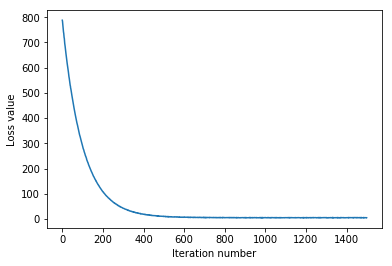

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370204
validation accuracy: 0.384000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in np.logspace(-7,-4,10):
    for rs in np.arange(regularization_strengths[0],regularization_strengths[1],np.diff(regularization_strengths)/10):
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                              num_iters=1000, verbose=True)
        
        Yt = svm.predict(X_train)
        Yp = svm.predict(X_val)
        
        t_num_correct = np.sum(Yt == y_train)
        t_accuracy = float(t_num_correct) / X_train.shape[0]
        
        v_num_correct = np.sum(Yp == y_val)
        v_accuracy = float(v_num_correct) / X_val.shape[0]
        
        results[(lr,rs)] = (t_accuracy ,v_accuracy)
        
        if (best_val<v_accuracy):
            best_val = v_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 787.959228
iteration 100 / 1000: loss 285.739146
iteration 200 / 1000: loss 106.858658
iteration 300 / 1000: loss 42.260097
iteration 400 / 1000: loss 18.777131
iteration 500 / 1000: loss 9.990901
iteration 600 / 1000: loss 6.996069
iteration 700 / 1000: loss 6.393997
iteration 800 / 1000: loss 5.847828
iteration 900 / 1000: loss 5.266571
iteration 0 / 1000: loss 883.209753
iteration 100 / 1000: loss 291.571127
iteration 200 / 1000: loss 99.766127
iteration 300 / 1000: loss 36.160276
iteration 400 / 1000: loss 15.663899
iteration 500 / 1000: loss 8.710549
iteration 600 / 1000: loss 6.289606
iteration 700 / 1000: loss 5.408744
iteration 800 / 1000: loss 5.299582
iteration 900 / 1000: loss 5.246534
iteration 0 / 1000: loss 948.843841
iteration 100 / 1000: loss 284.107190
iteration 200 / 1000: loss 88.864060
iteration 300 / 1000: loss 29.307723
iteration 400 / 1000: loss 12.972605
iteration 500 / 1000: loss 8.308069
iteration 600 / 1000: loss 6.876864
iteration 70

iteration 600 / 1000: loss 5.415620
iteration 700 / 1000: loss 5.607840
iteration 800 / 1000: loss 6.027271
iteration 900 / 1000: loss 6.656960
iteration 0 / 1000: loss 1018.511824
iteration 100 / 1000: loss 7.433010
iteration 200 / 1000: loss 5.621980
iteration 300 / 1000: loss 5.592084
iteration 400 / 1000: loss 5.755761
iteration 500 / 1000: loss 6.178772
iteration 600 / 1000: loss 5.798188
iteration 700 / 1000: loss 6.436308
iteration 800 / 1000: loss 5.573876
iteration 900 / 1000: loss 5.936342
iteration 0 / 1000: loss 1097.606115
iteration 100 / 1000: loss 7.023526
iteration 200 / 1000: loss 5.599602
iteration 300 / 1000: loss 6.109078
iteration 400 / 1000: loss 5.501371
iteration 500 / 1000: loss 5.731113
iteration 600 / 1000: loss 5.815330
iteration 700 / 1000: loss 6.198909
iteration 800 / 1000: loss 6.145668
iteration 900 / 1000: loss 6.469148
iteration 0 / 1000: loss 1164.839431
iteration 100 / 1000: loss 7.285255
iteration 200 / 1000: loss 5.887818
iteration 300 / 1000: los

iteration 300 / 1000: loss 12.061988
iteration 400 / 1000: loss 10.864221
iteration 500 / 1000: loss 16.651588
iteration 600 / 1000: loss 12.330111
iteration 700 / 1000: loss 12.100935
iteration 800 / 1000: loss 9.529177
iteration 900 / 1000: loss 14.461525
iteration 0 / 1000: loss 1245.685401
iteration 100 / 1000: loss 12.270377
iteration 200 / 1000: loss 11.550868
iteration 300 / 1000: loss 14.933232
iteration 400 / 1000: loss 14.967520
iteration 500 / 1000: loss 10.063976
iteration 600 / 1000: loss 13.105214
iteration 700 / 1000: loss 11.017074
iteration 800 / 1000: loss 9.020658
iteration 900 / 1000: loss 11.438681
iteration 0 / 1000: loss 1317.231357
iteration 100 / 1000: loss 12.939956
iteration 200 / 1000: loss 11.607363
iteration 300 / 1000: loss 11.807573
iteration 400 / 1000: loss 11.888326
iteration 500 / 1000: loss 12.981204
iteration 600 / 1000: loss 10.406423
iteration 700 / 1000: loss 10.853990
iteration 800 / 1000: loss 10.888479
iteration 900 / 1000: loss 9.583281
iter

iteration 500 / 1000: loss 106.652220
iteration 600 / 1000: loss 59.992439
iteration 700 / 1000: loss 75.884815
iteration 800 / 1000: loss 107.554304
iteration 900 / 1000: loss 83.475420
iteration 0 / 1000: loss 1414.161606
iteration 100 / 1000: loss 82.978844
iteration 200 / 1000: loss 115.607573
iteration 300 / 1000: loss 103.305578
iteration 400 / 1000: loss 95.082451
iteration 500 / 1000: loss 92.799051
iteration 600 / 1000: loss 119.995194
iteration 700 / 1000: loss 110.400711
iteration 800 / 1000: loss 93.144908
iteration 900 / 1000: loss 123.195199
iteration 0 / 1000: loss 1476.985959
iteration 100 / 1000: loss 137.994563
iteration 200 / 1000: loss 100.068277
iteration 300 / 1000: loss 115.836155
iteration 400 / 1000: loss 97.025609
iteration 500 / 1000: loss 124.645036
iteration 600 / 1000: loss 108.345365
iteration 700 / 1000: loss 109.061558
iteration 800 / 1000: loss 95.736110
iteration 900 / 1000: loss 89.458356
iteration 0 / 1000: loss 794.441967
iteration 100 / 1000: loss

C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:102: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(Loss_i, axis=0) / N_train + reg*np.sum(W*W)
C:\Users\Jnani\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:102: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(Loss_i, axis=0) / N_train + reg*np.sum(W*W)


iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
iteration 0 / 1000: loss 945.408052
iteration 100 / 1000: loss 373845097884171536932096871885367901559766947935027200.000000
iteration 200 / 1000: loss 79079390888767407442256568545274025852803927420431622526824733337455877080980760486186121437553077780480.000000
iteration 300 / 1000: loss 16727650298830471967148538412460683270602253369306142656504608853796489885263162281805091361350401309182121469909342743935771233587642163212320780750684160.000000
iteration 400 / 1000: loss 3538397063699545504178700879640733001409972622846421264447187389116504624184895805061333466267394970172900869767419169026756811763553853775157822322233275076842329500346754174580434697443813383784720498688.000000
iteration 500 / 1000: loss 7484765377521629517421836397404702634297561066899854595858304787316581077337202442890848270744829574770905183568438400443393828038349842438232413578294503494062634421065434975613351898292926216550639686037248090374560

C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:93: RuntimeWarning: overflow encountered in subtract
  score_diffs = scores - np.expand_dims(correct_scores, -1) + 1 #add delta=1
C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:132: RuntimeWarning: overflow encountered in multiply
  dW += 2*reg*W
C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:93: RuntimeWarning: invalid value encountered in subtract
  score_diffs = scores - np.expand_dims(correct_scores, -1) + 1 #add delta=1
C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:96: RuntimeWarning: invalid value encountered in maximum
  score_diffs_capped = np.maximum(np.zeros(score_diffs.shape),score_diffs)
C:\Users\Jnani\Desktop\classwork\hw1\assignment1\cs231n\classifiers\linear_svm.py:121: RuntimeWarning: invalid value encountered in greater
  dw_col[score_diffs_capped>0] = 1 #representative of the result 

iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1176.078912
iteration 100 / 1000: loss 11962124736054311685438588295657800324940008412187304239340059365481366807430299648.000000
iteration 200 / 1000: loss 102298590552064777562128762238039219299842852231925236402566362330358004240436160241916011340827208050846784433348406201222975642332461257555636016683607551639552.000000
iteration 300 / 1000: loss 874844716958775047692968267899853927802147970224496559049543341757553908631003104748252229785738361877619796133373410183890354185375405057857872226786437312477584913408890075360152397018785685596426795923081619387104718616802705473020100608.000000
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1250.953384
iteration 100 / 1000: loss 744145002760271201717377830109461502443553882190016970966554877691594074914667884160483328.0

iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1337.222378
iteration 100 / 1000: loss 14555570140468092997792013123813771226079810569319277221828065733049351972788407327319869544723961209194719280302788073208753442960930319464290688292862888404905843825787612954624.000000
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1399.069280
iteration 100 / 1000: loss 6145281587897685163171862078717187666852551475939882518996312245445899297347063847389505332994610754313725159282390883460763610045722448657732184662786216695863524610261678002981044224.0000

NameError: name 'reg' is not defined

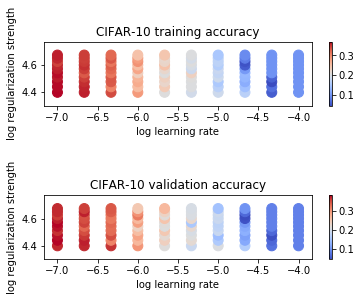

In [16]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(3, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(3, 1, 3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.354000


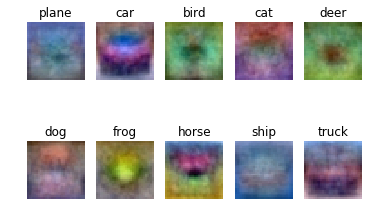

In [18]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 

The svm weights look like very blurry representatives of pictures containing that class of object, down even to the background color. The blurry and somewhat circular/centered look is likely an attempt by the model to build some position invariance into the templates to successfully classify the objects in images taken from various angles.
